<a href="https://colab.research.google.com/github/Sandikadata/Twitter-News/blob/main/Twitter_News_Financial_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Sandikadata/Twitter-News.git

Cloning into 'Twitter-News'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), done.
Resolving deltas: 100% (1/1), done.


**Importing Libraries**

In [ ]:
import pandas as pd
import re
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import accuracy_score, classification_report

**Loading Data**

In [ ]:
train_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_data.csv')
test_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/valid_data.csv')

In [ ]:
print(train_df.shape)
print(test_df.shape)

(16990, 5)
(4117, 5)


In [ ]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16990 entries, 0 to 16989
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text             16990 non-null  object 
 1   label            16990 non-null  int64  
 2   sentiment_score  16990 non-null  float64
 3   sentiment        16990 non-null  object 
 4   clean_text       16990 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 663.8+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4117 entries, 0 to 4116
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text             4117 non-null   object 
 1   label            4117 non-null   int64  
 2   sentiment_score  4117 non-null   float64
 3   sentiment        4117 non-null   object 
 4   clean_text       4117 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 160.9+ KB


**EXPLORATORY DATA ANALYSIS**

In [ ]:
train_df.head()

,text,label,sentiment_score,sentiment
0,Here are Thursday's biggest analyst calls: App...,0,0.1779,positive
1,Buy Las Vegas Sands as travel to Singapore bui...,0,0.2500,positive
2,"Piper Sandler downgrades DocuSign to sell, cit...",0,-0.2732,Negative
3,"Analysts react to Tesla's latest earnings, bre...",0,0.0000,Neutral
4,Netflix and its peers are set for a ‘return to...,0,0.3400,positive


In [ ]:
train_df.tail()

,text,label,sentiment_score,sentiment
16985,KfW credit line for Uniper could be raised to ...,3,0.3818,positive
16986,KfW credit line for Uniper could be raised to ...,3,0.3818,positive
16987,Russian https://t.co/R0iPhyo5p7 sells 1 bln r...,3,0.0000,Neutral
16988,Global ESG bond issuance posts H1 dip as supra...,3,-0.2732,Negative
16989,Brazil's Petrobras says it signed a $1.25 bill...,3,0.0000,Neutral


In [ ]:
test_df.head()

,text,label,sentiment_score,sentiment
0,Analyst call of the day for @CNBCPro subscribe...,0,0.0000,Neutral
1,"Loop upgrades CSX to buy, says it's a good pla...",0,0.0258,positive
2,BofA believes we're already in a recession — a...,0,-0.4215,Negative
3,JPMorgan sees these derivative plays as best w...,0,0.7351,positive
4,Morgan Stanley's Huberty sees Apple earnings m...,0,-0.0772,Negative


In [ ]:
test_df.tail()

,text,label,sentiment_score,sentiment
4112,Dollar bonds of Chinese developers fall as str...,3,-0.4215,Negative
4113,Longer maturity Treasury yields have scope to ...,3,-0.1027,Negative
4114,Pimco buys €1bn of Apollo buyout loans from ba...,3,0.0000,Neutral
4115,Analysis: Banks' snubbing of junk-rated loan f...,3,-0.6124,Negative
4116,U.S. Treasury seeks information on digital ass...,3,0.2960,positive


In [ ]:
train_df.describe()

,label,sentiment_score
count,16990.000000,16990.000000
mean,9.547616,0.068121
std,6.401000,0.359175
min,0.000000,-0.959000
25%,2.000000,0.000000
50%,9.000000,0.000000
75%,16.000000,0.318200
max,19.000000,0.962500


**SENTIMENT ANALYSIS**

In [ ]:
temp = train_df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,Neutral,6624
2,positive,6567
0,Negative,3799


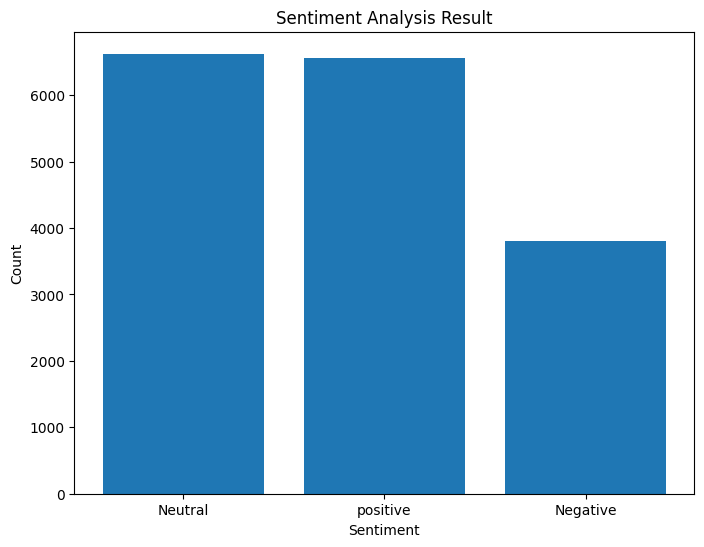

In [ ]:
sentiment_count=train_df['sentiment'].value_counts()
plt.figure(figsize=(8,6))
plt.bar(sentiment_count.index,sentiment_count.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Analysis Result')
plt.show()

In [ ]:
from plotly import graph_objs as go

In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

**Cleaning the Corpus**

In [ ]:
def clean_text(text):
  text=text.lower()
  text=re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  text=re.sub(r'\@\W+|\#','',text)
  text=re.sub(r'[^\w\s]','',text)
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  return text.strip()

In [ ]:
train_df['clean_text']=train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

In [ ]:
print(train_df.columns)
print(train_df.head(20))


Index(['text', 'label', 'sentiment_score', 'sentiment', 'clean_text'], dtype='object')
                                                 text  label  sentiment_score  \
0   Here are Thursday's biggest analyst calls: App...      0           0.1779   
1   Buy Las Vegas Sands as travel to Singapore bui...      0           0.2500   
2   Piper Sandler downgrades DocuSign to sell, cit...      0          -0.2732   
3   Analysts react to Tesla's latest earnings, bre...      0           0.0000   
4   Netflix and its peers are set for a ‘return to...      0           0.3400   
5   Barclays believes earnings for these underperf...      0           0.2732   
6   Bernstein upgrades Alibaba, says shares can ra...      0           0.2960   
7   Analysts react to Netflix's strong quarter, wi...      0           0.5106   
8   Buy Chevron as shares look attractive at these...      0           0.6249   
9   Morgan Stanley says these global stocks are se...      0           0.0000   
10  Investing Club: An

In [ ]:
print(test_df.columns)
print(test_df.head(20))

Index(['text', 'label', 'sentiment_score', 'sentiment', 'clean_text'], dtype='object')
                                                 text  label  sentiment_score  \
0   Analyst call of the day for @CNBCPro subscribe...      0           0.0000   
1   Loop upgrades CSX to buy, says it's a good pla...      0           0.0258   
2   BofA believes we're already in a recession — a...      0          -0.4215   
3   JPMorgan sees these derivative plays as best w...      0           0.7351   
4   Morgan Stanley's Huberty sees Apple earnings m...      0          -0.0772   
5   Analyst call of the day for @CNBCPro subscribe...      0           0.1779   
6   Here are Wednesday's biggest analyst calls: Ne...      0           0.1779   
7   Analyst call of the day for @CNBCPro subscribe...      0          -0.3612   
8   Oppenheimer ups Dollar General price target, s...      0           0.0516   
9   Piper Sandler downgrades solar stocks, sees no...      0          -0.2960   
10  Mizuho says Wall S

**Wordcloud Trend Analysis**

In [ ]:
def trend_analysis(df, title):
    text_data = ' '.join(train_df['clean_text'].astype(str))  # Convert all text data into a single string
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)  # Generate word cloud

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')  # Now wordcloud is defined
    plt.axis('off')
    plt.title(title)
    plt.show()

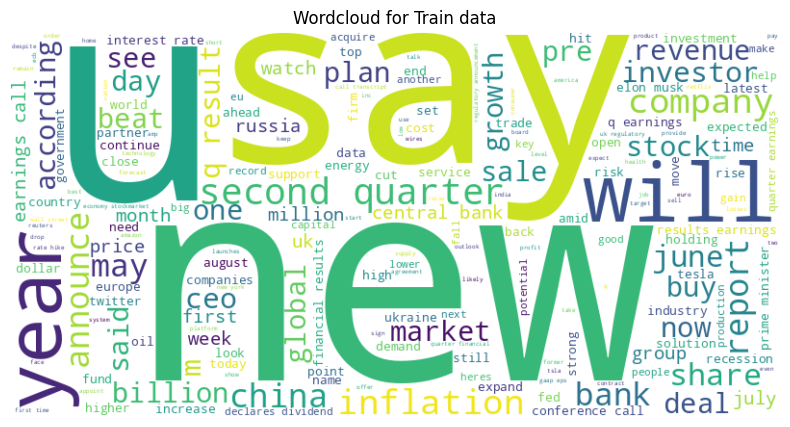

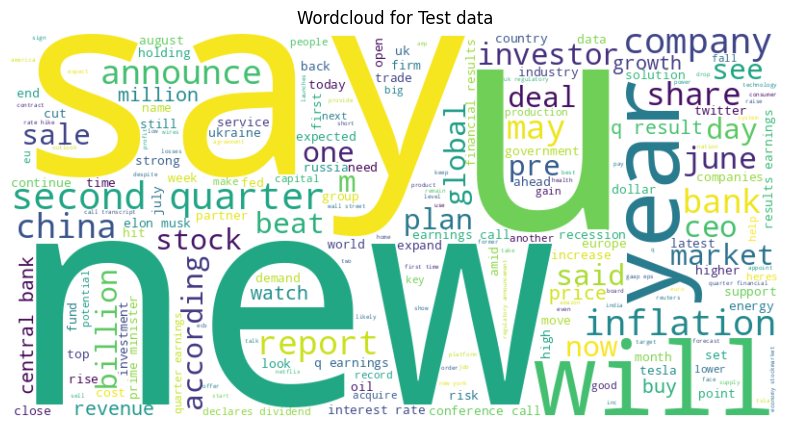

In [ ]:
trend_analysis(train_df,'Wordcloud for Train data')
trend_analysis(test_df,'Wordcloud for Test data')

**Machine Learing Modeling**

**TF-IDF Vectorization**

In [ ]:
tdidf_vectorizer=TfidfVectorizer(stop_words='english',max_features=5000)
X_train_tfidf=tdidf_vectorizer.fit_transform(train_df['clean_text'])
X_test_tfidf=tdidf_vectorizer.transform(test_df['clean_text'])

**Count Vectorization**

In [ ]:
count_vectorizer=CountVectorizer(stop_words='english',max_features=5000)
X_train_count=count_vectorizer.fit_transform(train_df['clean_text'])
X_test_count=count_vectorizer.transform(test_df['clean_text'])
y_train, y_test = train_df['label'], test_df['label']

In [ ]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix

**LogisticRegression**

In [ ]:

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_tfidf, y_train)
preds_logistic = logistic_model.predict(X_test_tfidf)
print("Logistic Regression Sentiment Analysis Accuracy:", accuracy_score(y_test, preds_logistic))
print("Logistic Regression Classification Report:\n", classification_report(y_test, preds_logistic))

Logistic Regression Sentiment Analysis Accuracy: 0.7782365800340053
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.45      0.62        73
           1       0.83      0.75      0.79       214
           2       0.69      0.91      0.78       852
           3       0.92      0.57      0.70        77
           4       0.99      0.89      0.93        97
           5       0.92      0.91      0.91       242
           6       0.79      0.73      0.75       146
           7       0.88      0.78      0.83       160
           8       0.92      0.38      0.53        32
           9       0.66      0.68      0.67       336
          10       0.29      0.15      0.20        13
          11       1.00      0.36      0.53        14
          12       0.96      0.61      0.75       119
          13       0.85      0.48      0.62       116
          14       0.73      0.80      0.76       415
          15       0.83

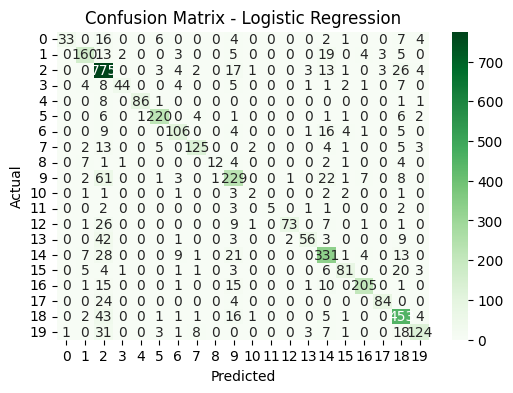

In [ ]:
#Confusion Matrix for Logistic Regression
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, preds_logistic), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Naive Bayes**

In [ ]:

model_tfidf = MultinomialNB()
model_tfidf.fit(X_train_tfidf, y_train)
preds_tfidf = model_tfidf.predict(X_test_tfidf)
print("TF-IDF Sentiment Analysis Accuracy:", accuracy_score(y_test, preds_tfidf))
print("TF-IDF Classification Report:\n", classification_report(y_test, preds_tfidf))

model_count = MultinomialNB()
model_count.fit(X_train_count, y_train)
preds_count = model_count.predict(X_test_count)
print("Count Vectorization Sentiment Analysis Accuracy:", accuracy_score(y_test, preds_count))
print("Count Vectorization Classification Report:\n", classification_report(y_test, preds_count))

TF-IDF Sentiment Analysis Accuracy: 0.711197473888754
TF-IDF Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.11      0.20        73
           1       0.88      0.68      0.77       214
           2       0.60      0.92      0.73       852
           3       1.00      0.19      0.33        77
           4       0.99      0.86      0.92        97
           5       0.89      0.86      0.87       242
           6       0.88      0.41      0.56       146
           7       0.85      0.70      0.77       160
           8       1.00      0.16      0.27        32
           9       0.72      0.58      0.64       336
          10       0.00      0.00      0.00        13
          11       0.00      0.00      0.00        14
          12       0.98      0.48      0.64       119
          13       1.00      0.15      0.26       116
          14       0.59      0.84      0.69       415
          15       0.95      0.45      0.61       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



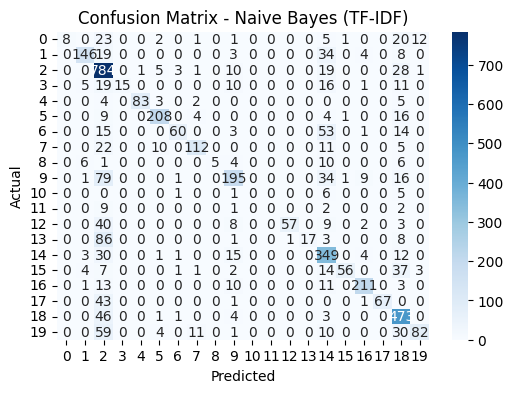

In [ ]:
# Confusion Matrix for Naive Bayes (TF-IDF)

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, preds_tfidf), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Naive Bayes (TF-IDF)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Topic Modeling**

In [ ]:

X_topics = count_vectorizer.fit_transform(train_df['clean_text'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_topics)

def display_topics(model, feature_names, n_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx+1}: ", [feature_names[i] for i in topic.argsort()[-n_words:]])

display_topics(lda, count_vectorizer.get_feature_names_out())


Topic 1:  ['investors', 'new', 'stockmarket', 'investing', 'trading', 'economy', 'finance', 'business', 'markets', 'stocks']
Topic 2:  ['company', 'said', 'covid', 'elon', 'musk', 'deal', 'says', 'eps', 'beats', 'revenue']
Topic 3:  ['million', 'uk', 'declares', 'dividend', 'results', 'financial', 'new', 'second', 'announces', 'quarter']
Topic 4:  ['rates', 'earnings', 'gas', 'year', 'june', 'bank', 'oil', 'rate', 'prices', 'inflation']
Topic 5:  ['markets', 'investing', 'spy', 'economy', 'business', 'results', 'stockmarket', 'stocks', 'trading', 'earnings']


In [ ]:
x_new=X_train_tfidf[200]
print(y_test[200])
prediction=logistic_model.predict(x_new)
print(prediction)
if prediction[0]==0:
  print('Negative Tweet')
else:
    print ('Positive Tweet')

2
[14]
Positive Tweet
